# Datasets and Dataloaders

PyTorch 提供了两个数据原语： torch.utils.data.DataLoader 和 torch.utils.data.Dataset ，允许使用预加载的数据集以及自己的数据。 

Dataset存储样本及其相应的标签， DataLoader围绕Dataset包装一个可迭代对象，以便轻松访问样本。

## 1.加载数据集

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data", # root是存储训练/测试数据的路径，
    train=True, # train指定训练或测试数据集
    download=True, # download=True从互联网下载数据（如果root不可用）。
    transform=ToTensor() # transform和target_transform指定特征和标签变换
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

## 2.迭代和可视化数据集

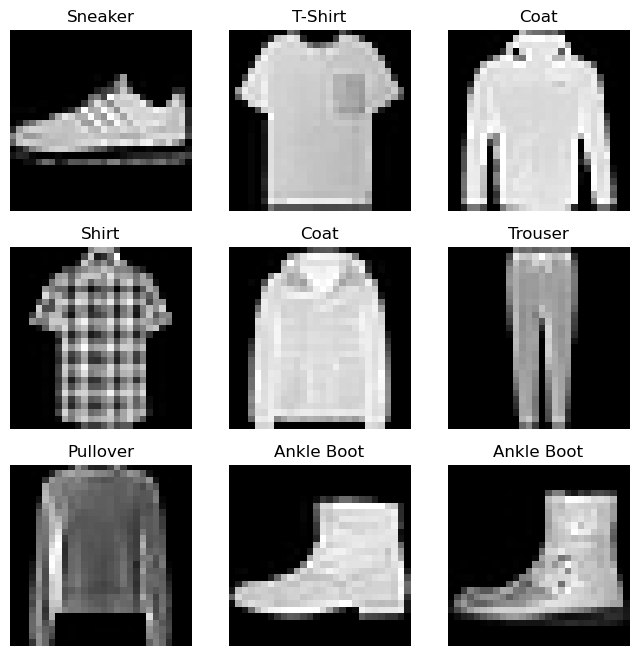

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()